<a href="https://colab.research.google.com/drive/10HgkRiW-3MKV1DB9Nygz0hatcDpXhrEj?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2024 6.8200 Computational Sensorimotor Learning Assignment 5

In this assignment, we will tackle the sim2real gap in deep reinforcement learning. Since we don't have access to a real-world system, we will mimic sim-to-real transfer via sim-to-sim transfer (where one simulator is a replacement for the physical world).

There are 280 total points on this problem set.

## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install git+https://github.com/idanshen/easyrl.git@sac > /dev/null 2>&1

In [2]:
%matplotlib inline

import gym
from gym import spaces
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import torch
from tqdm import tqdm
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from torch import nn
from pathlib import Path
import math
import glob
import io
import base64
from IPython.display import HTML
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from easyrl.agents.ppo_agent import PPOAgent
from easyrl.configs import cfg
from easyrl.configs import set_config
from easyrl.configs.command_line import cfg_from_cmd
from easyrl.engine.ppo_engine import PPOEngine
from easyrl.models.categorical_policy import CategoricalPolicy
from easyrl.models.diag_gaussian_policy import DiagGaussianPolicy
from easyrl.models.mlp import MLP
from easyrl.models.value_net import ValueNet
from easyrl.runner.nstep_runner import EpisodicRunner
from easyrl.utils.common import set_random_seed
from easyrl.utils.gym_util import make_vec_env
from easyrl.utils.common import load_from_json
from gym.envs.classic_control.acrobot import AcrobotEnv
from gym.envs.registration import registry, register
from IPython import display as ipythondisplay

In [3]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
stolen from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=8nj5sjsk15IT
"""

def show_video():
    """
    Displays the recorded video of the gym environment.
    """
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    """
    Wraps the given gym environment to record videos.

    Parameters:
        env (gym.Env): The environment to wrap.

    Returns:
        gym.Env: The wrapped environment.
    """
    env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
    return env

def read_tf_log(log_dir, scalar='train/episode_return/mean'):
    """
    Reads the TensorFlow event log file and retrieves scalar data.

    Parameters:
        log_dir (str): The directory containing the log files.
        scalar (str): The name of the scalar to retrieve.

    Returns:
        tuple: A tuple containing lists of steps and corresponding scalar values.
               Returns None if no log files found.
    """
    log_dir = Path(log_dir)
    log_files = list(log_dir.glob(f'**/events.*'))
    if len(log_files) < 1:
        return None
    log_file = log_files[0]

    event_acc = EventAccumulator(log_file.as_posix())
    event_acc.Reload()
    tags = event_acc.Tags()

    scalar_return = event_acc.Scalars(scalar)
    returns = [x.value for x in scalar_return]
    steps = [x.step for x in scalar_return]

    return steps, returns

class AcrobotTargetEnv(AcrobotEnv):
    """
    Customized Acrobot environment with target modifications.
    """
    book_or_nips = "nips"


env_name = 'AcrobotTargetEnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:AcrobotTargetEnv',
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Experiment Running

We've provided the below code as-is to run your experiments using PPO.  Please do not modify this function.

In [4]:
# DO NOT MODIFY THIS
def train_ppo(env_name='Acrobot-v1', max_steps=100000):
    """
    Train the Proximal Policy Optimization (PPO) agent on the specified environment.

    Parameters:
        env_name (str): Name of the Gym environment to train on.
        max_steps (int): Maximum number of training steps.

    Returns:
        tuple: A tuple containing the trained agent and the directory where the training data is saved.
    """
    set_config('ppo')
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 1024
    cfg.alg.log_interval = 1
    cfg.alg.eval_interval = 20

    cfg.alg.max_steps = max_steps
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = env_name
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += '/' + env_name

    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'      Total number of steps:{cfg.alg.max_steps}')
    print(f'====================================')

    set_random_seed(cfg.alg.seed)

    env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed)
    env.reset()
    ob_size = env.observation_space.shape[0]

    actor_body = MLP(input_size=ob_size,
                     hidden_sizes=[64, 64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)

    critic_body = MLP(input_size=ob_size,
                     hidden_sizes=[64, 64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)

    if isinstance(env.action_space, gym.spaces.Discrete):
        act_size = env.action_space.n
        actor = CategoricalPolicy(actor_body,
                                 in_features=64,
                                 action_dim=act_size)
    elif isinstance(env.action_space, gym.spaces.Box):
        act_size = env.action_space.shape[0]
        actor = DiagGaussianPolicy(actor_body,
                                   in_features=64,
                                   action_dim=act_size,
                                   tanh_on_dist=cfg.alg.tanh_on_dist,
                                   std_cond_in=cfg.alg.std_cond_in)
    else:
        raise TypeError(f'Unknown action space type: {env.action_space}')

    critic = ValueNet(critic_body, in_features=64)
    agent = PPOAgent(actor=actor, critic=critic, env=env)
    runner = EpisodicRunner(agent=agent, env=env)
    engine = PPOEngine(agent=agent,
                       runner=runner)
    engine.train()

    return agent, cfg.alg.save_dir


# Acrobot Introduction

Ben Bitdiddle just started his graduate program studying the *Acrobot*: a double pendulum commonly used as a benchmark in continuous control.  The goal of the benchmark is to find a policy that can swing the tip of the pendulum above the plane defined by the first joint (see the figure below), while only exerting torques on the second joint.  The sooner you hit the termination plane, the higher the reward.

**Henceforth, whenever we ask you to evaluate performance, we generally mean the mean and the standard deviation of steps it took to hit the termination plane.**

Lab time on the Acrobot is highly contested: Ben can only book 20 minute slots of physical time with the device. Thankfully, OpenAI gym provides a simulation environment for the Acrobot with the exact same physical parameters!

Run the below cell to train a PPO policy in this simulation environment, and report whether Ben Bitdiddle should expect to be able to use the same method to train a policy on the real Acrobot.

![](https://www.researchgate.net/publication/332779048/figure/fig8/AS:753590863937537@1556681471025/Acrobot-environment.ppm)

In [5]:
agent, save_dir = train_ppo(env_name="Acrobot-v1")

[INFO][2024-03-20 19:15:44]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-20 19:15:44]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.


      Device:cuda
      Total number of steps:100000


[ERROR][2024-03-20 19:15:46]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
[INFO][2024-03-20 19:15:49]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-20 19:15:49]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-20 19:15:49]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/model_best.pt.
[INFO][2024-03-20 19:16:42]: Exploration steps: 20480
INFO:EasyRL:Exploration steps: 20480
[INFO][2024-03-20 19:16:42]: Saving checkpoint: /con

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


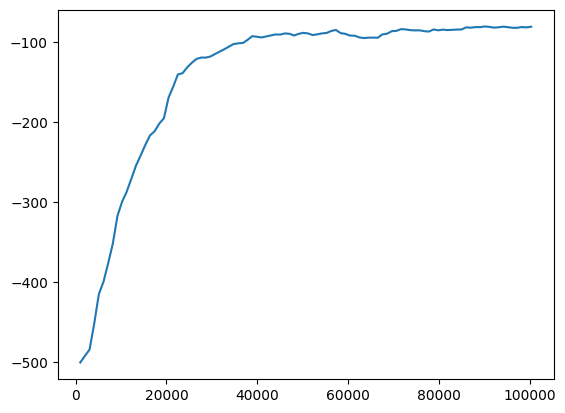

In [6]:
steps, returns = read_tf_log(save_dir)
plt.plot(steps, returns)

In [7]:
# Displays a video of the policy.
# Feel free to use this as a template for debugging.

env = wrap_env(gym.make('Acrobot-v1'))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):
        action = agent.get_action(observation)[0].tolist()
        observation, reward, done, info = env.step(action)
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
print(f'mean: {np.mean(num_steps)}, std: {np.std(num_steps)}')
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Num steps: [71, 70, 75, 80, 76, 83, 70, 69, 86, 86]
mean: 76.6, std: 6.390618123468183


**Question (10 pts):** Will Ben Bitdittle have enough time to train a policy on the real robot using the same PPO implementation as above? Note that each simulation step is equivalent to 0.2 seconds of time on the real robot.

**Answer:** The training in simulator above started to converge around 30k-th step, which corresponds to 6k sec = 100 min. This is much larger than the time limit of 20 min. Therefore, the training is not likely to converge in real world.

# The Sim2Real Gap

Ben is devastated by the above result; how will he train a policy for the Acrobot if it won't converge in his allocated lab time?  

One idea is to simply train a policy in simulation, then evaluate that policy on the real robot (which takes far less time than training from scratch).  Let's try this out, using the environment `AcrobotTargetEnv-v0` as a stand-in for the real world.

In [8]:
### TODO: evaluate the agent from the simulation environment ("Acrobot-v1") in
### the real world environment ("AcrobotTargetEnv-v0"). Be sure to run at least 10 trials
### Report mean and standard deviation. (10 pts)

env = wrap_env(gym.make("AcrobotTargetEnv-v0"))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):
        action = agent.get_action(observation)[0].tolist()
        observation, reward, done, info = env.step(action)
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
print(f'mean: {np.mean(num_steps)}, std: {np.std(num_steps)}')
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Num steps: [144, 97, 181, 179, 140, 164, 166, 222, 130, 209]
mean: 163.2, std: 35.38587288735435


**Question (10 pts):** How does the policy trained in simulation perform when evaluated on the "real" robot?  If there's a difference in performance, postulate why that might be.

**Answer**: If we apply the simulator-trained policy to the real-world environment, the number of steps required to acheive the goal and it's variance has been increased. This is because of the discrepancy in physical parameters (e.g. mass, frictions,..etc) between the simulator and real world.

# System Identification

One reason for the gap Ben observed is a mismatch between physical parameters in the simulation and in the real world.  If you look at the [code for the Acrobot simulation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py#L143), you'll notice a series of parameters that define the simulator dynamics.  Perhaps a measurement error was made for one or more of these values, leading to a simulation that does not reflect reality.  One family of solutions for fixing these sorts of issues is *system identification*, which provides us tools for finding the correct values of these parameters from data.

In this section, you will use a gradient-free numerical optimizer of choice to improve upon the parameters in the Acrobot simulation, with the goal of most closely matching the real world `AcrobotTargetEnv-v0` environment.

Start by generating data of tuples (`env.state`, action, obs) from the real world environment, `AcrobotTargetEnv-v0`, over which to perform your system identification. Later, we'll want the best robot parameters such that when we apply the recorded action when the environment state is the recorded `env.state`, we get as close to the recorded obs as possible.

You can generate as much data as you'd like as long as you don't use more than 20 minutes of robot time (e.g., $\frac{20\text{ minutes}}{0.2\text{ seconds/timestep}} =6000\text{ timesteps}$ ).

In [9]:
q_shape = 4
u_shape = 1
obs_shape = 6
dataset = {
    "env_state": np.zeros((6000,q_shape)),
    "action": np.zeros((6000,u_shape)),
    "new_obs": np.zeros((6000,obs_shape)),
}

### TODO: generate your data for system ID (10 pts)
env = gym.make("AcrobotTargetEnv-v0")
num_steps = 0
while num_steps < 6000:
    observation = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()

        dataset["env_state"][num_steps] = observation[:q_shape]
        dataset["action"][num_steps] = action

        observation, _, done, _ = env.step(action)
        dataset["new_obs"][num_steps] = observation[:obs_shape]

        num_steps += 1
        if num_steps >= 6000:
            break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now, try to find parameters that yield new observations that best match your dataset.  There are a number of optimization methods to do this, but for our purposes let's do a simple random search of values in the neighborhood of those that we already have. Specifically, let's randomly and individually scale these parameters from 90% to 110% of their default values (mentioned in the code cell below) and see what combination yields the best performance.

To evaluate your randomly sampled parameters, load the parameters into your `AcrobatSystemIDEnv` and see if for the same environment state and action, how much the next observations differ in terms of L2-norm. Take the mean difference in L2 norm and pick the parameters with the lowest mean difference between prediction and observed.

In [10]:
class AcrobotSystemIDEnv(AcrobotEnv):
    """
    Customized Acrobot environment for system identification.

    This environment allows for customization of various parameters related to the Acrobot dynamics.

    Parameters:
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Keyword Arguments:
        dt (float): Time step for the environment dynamics.
        LINK_LENGTH_1 (float): Length of the first link in the Acrobot.
        LINK_LENGTH_2 (float): Length of the second link in the Acrobot.
        LINK_MASS_1 (float): Mass of the first link in the Acrobot.
        LINK_MASS_2 (float): Mass of the second link in the Acrobot.
        LINK_COM_POS_1 (float): Position of the center of mass of the first link.
        LINK_COM_POS_2 (float): Position of the center of mass of the second link.
        LINK_MOI (float): Moment of inertia of the links.
        MAX_VEL_1 (float): Maximum angular velocity for the first joint.
        MAX_VEL_2 (float): Maximum angular velocity for the second joint.
    """
    def __init__(self, *args, **kwargs):
        for param in ['dt', 'LINK_LENGTH_1', 'LINK_LENGTH_2', 'LINK_MASS_1',
                      'LINK_MASS_2', 'LINK_COM_POS_1', 'LINK_COM_POS_2',
                      'LINK_MOI', 'MAX_VEL_1', 'MAX_VEL_2']:
            if param in kwargs:
                setattr(self, param, kwargs[param])
                del kwargs[param]

        super().__init__(*args, **kwargs)

default_params = {
    'dt' : 0.2,
    'LINK_LENGTH_1' : 1.0,
    'LINK_LENGTH_2' : 1.0,
    'LINK_MASS_1' : 1.0,
    'LINK_MASS_2' : 1.0,
    'LINK_COM_POS_1' : 0.5,
    'LINK_COM_POS_2' : 0.5,
    'LINK_MOI' : 1.0,
    'MAX_VEL_1' : 4 * np.pi,
    'MAX_VEL_2' : 9 * np.pi,
}

### TODO: find parameters of AcrobotSystemIDEnv that match the data in `dataset`,
### and populate them into `best_params` (30 pts)
from tqdm.notebook import tqdm
from copy import deepcopy

min_loss = float('inf')
best_params = None

for i in tqdm(range(50)):
    ## sample randomly from 0.9-1.1 scale
    scaling_factors = np.random.uniform(0.9, 1.1, size=len(default_params))
    params = deepcopy(default_params)

    for j, param in enumerate(default_params.keys()):
        params[param] *= scaling_factors[j]


    ## obtain "new_obs_tmp" using previous dataset for calculating loss
    env_tmp = AcrobotSystemIDEnv()
    env_tmp.dt = params['dt']
    env_tmp.LINK_LENGTH_1 = params['LINK_LENGTH_1']
    env_tmp.LINK_LENGTH_2 = params['LINK_LENGTH_2']
    env_tmp.LINK_MASS_1 = params['LINK_MASS_1']
    env_tmp.LINK_MASS_2 = params['LINK_MASS_2']
    env_tmp.LINK_COM_POS_1 = params['LINK_COM_POS_1']
    env_tmp.LINK_COM_POS_2 = params['LINK_COM_POS_2']
    env_tmp.LINK_MOI = params['LINK_MOI']
    env_tmp.MAX_VEL_1 = params['MAX_VEL_1']
    env_tmp.MAX_VEL_2 = params['MAX_VEL_2']

    observation = env_tmp.reset()
    loss = 0
    for num_steps in range(6000):
        action = int(dataset["action"][num_steps][0])

        new_observation, _, done, _ = env_tmp.step(action)[:4]
        new_obs_tmp = new_observation[:obs_shape]

        if done:
            env_tmp.reset()

        loss += np.linalg.norm(new_obs_tmp - dataset["new_obs"][num_steps])

    loss = loss/6000

    if loss < min_loss:
        min_loss = loss
        best_params = params

print(best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

{'dt': 0.18658776625991652, 'LINK_LENGTH_1': 1.0242956802999528, 'LINK_LENGTH_2': 1.0154457177208336, 'LINK_MASS_1': 0.9475785642749017, 'LINK_MASS_2': 1.0868427995849588, 'LINK_COM_POS_1': 0.5113965955965897, 'LINK_COM_POS_2': 0.5035632803024959, 'LINK_MOI': 1.0179819952709144, 'MAX_VEL_1': 13.14473035624642, 'MAX_VEL_2': 27.2109078850984}


Awesome!  Let's now try to train a policy in a simulation environment with those params loaded, `AcrobotSystemIDSolvedEnv`, and see if we do any better.

In [11]:
class AcrobotSystemIDSolvedEnv(AcrobotEnv):
    """
    Customized Acrobot environment for system identification with predefined best parameters.

    This environment sets specific parameters to predefined values for solving the Acrobot system identification task.

    Parameters:
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.
    """
    def __init__(self, *args, **kwargs):
        """
        Initializes the AcrobotSystemIDSolvedEnv with predefined best parameters.

        Parameters:
            *args: Variable length argument list.
            **kwargs: Arbitrary keyword arguments.
        """
        for param in best_params:
            print('Setting', param, 'to', best_params[param])
            setattr(self, param, best_params[param])

        super().__init__(*args, **kwargs)

env_name = 'AcrobotSystemIDSolvedEnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:AcrobotSystemIDSolvedEnv',
)

sysid_agent, sysid_save_dir = train_ppo(env_name='AcrobotSystemIDSolvedEnv-v0')

[INFO][2024-03-20 19:20:34]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-20 19:20:34]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[ERROR][2024-03-20 19:20:34]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages


      Device:cuda
      Total number of steps:100000
Setting dt to 0.18658776625991652
Setting LINK_LENGTH_1 to 1.0242956802999528
Setting LINK_LENGTH_2 to 1.0154457177208336
Setting LINK_MASS_1 to 0.9475785642749017
Setting LINK_MASS_2 to 1.0868427995849588
Setting LINK_COM_POS_1 to 0.5113965955965897
Setting LINK_COM_POS_2 to 0.5035632803024959
Setting LINK_MOI to 1.0179819952709144
Setting MAX_VEL_1 to 13.14473035624642
Setting MAX_VEL_2 to 27.2109078850984


[INFO][2024-03-20 19:20:37]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-20 19:20:37]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-20 19:20:37]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/model_best.pt.
[INFO][2024-03-20 19:21:21]: Exploration steps: 20480
INFO:EasyRL:Exploration steps: 20480
[INFO][2024-03-20 19:21:21]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/ckpt_000000020480.pt.
INFO:EasyRL:Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/ckpt_000000020480.pt.
[INFO][2024-03-20 19:21:21]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/model_best.pt.
INFO:EasyRL:Saving chec

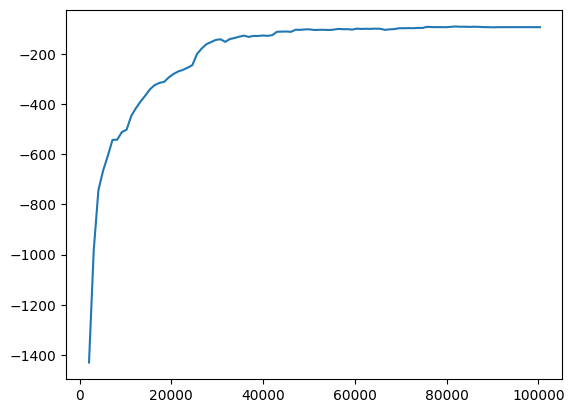

In [12]:
sysid_steps, sysid_returns = read_tf_log(sysid_save_dir)
plt.plot(sysid_steps, sysid_returns)

In [13]:
### TODO: evaluate the agent from the sysid simulation environment
### ("AcrobotSystemIDSolvedEnv-v0") in the real world environment
### ("AcrobotTargetEnv-v0"). Be sure to run at least 10 trials.
### Report mean and standard deviation. (10 pts)

env = wrap_env(gym.make("AcrobotTargetEnv-v0"))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):
        action = sysid_agent.get_action(observation)[0].tolist()
        observation, reward, done, info = env.step(action)
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
print(f'mean: {np.mean(num_steps)}, std: {np.std(num_steps)}')
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Num steps: [180, 172, 152, 155, 204, 329, 169, 197, 146, 182]
mean: 188.6, std: 50.08033546213524


**Question (10 pts):** How does the sysid agent perform when transferred on the "real" robot in comparison to our baseline agent trained in the "sim" (`Acrobot-v1`)?

**Answer:** By adjusting the physical parmaters towards real-world ones, we wished to observe a decreased number of steps to achieve the goal. However, the actual results showed an increased number. I believe it is in part because of the outlier of value 329 in the above result, and in part because the environment itself has a large run-to-run deviations.

**Question (10 pts):** How does the sysid agent perform when evaluated in its training env, `AcrobotSystemIDSolvedEnv-v0`. You may find plotting the returns during training to be helpful using `read_tf_log`?

**Answer:** The return converges to a certain value, meaning that the training could find the (sub)optimal policy.

**Question (10 pts):** Do you still observe a sim2real gap?  If so, why might that be, and how could it be further minimized?

**Answer:** Yes, I still have the sim2real gap, given that the the number of step is larger compared to the one in the simulator

# Domain Randomization

Fortunately, Ben's professor has another solution to improve the quality of transfer between simulation and reality: *domain randomization*.  A good summary of the concept can be found in the [original paper](https://arxiv.org/abs/1710.06537)'s abstract:

> Due to modeling error, strategies that are successful in simulation may not transfer to their real world counterparts. In this paper, we demonstrate a simple method to bridge this "reality gap". By randomizing the dynamics of the simulator during training, we are able to develop policies that are capable of adapting to very different dynamics, including ones that differ significantly from the dynamics on which the policies were trained. This adaptivity enables the policies to generalize to the dynamics of the real world without any training on the physical system.

Let's now implement dynamics randomization for Acrobot.


In [14]:
class AcrobotDREnv(AcrobotEnv):
    """
    Customized Acrobot environment for domain randomization.

    This environment extends the Acrobot environment to include domain randomization of parameters.

    Overrides the reset method to randomize the dynamics parameters within a certain range.

    Attributes:
        All attributes from the AcrobotEnv base class.
    """
    def reset(self):
        """
        Reset the environment and randomize the dynamics parameters slightly.

        Returns:
            numpy.ndarray: The initial observation after resetting the environment.
        """
        obs = super().reset()

        ### TODO: randomize the dynamics parameters from the defaults slightly
        ### similar to the sysid section (invidually and randomly scale 80% to 120%) (30 pts)
        scaling_factors = np.random.uniform(0.8, 1.2, size=len(obs))
        for i in range(len(obs)):
            obs[i] *= scaling_factors[i]
        ### ENDTODO

        return obs

env_name = 'AcrobotDREnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:AcrobotDREnv',
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
dr_agent, dr_save_dir = train_ppo(env_name='AcrobotDREnv-v0')

[INFO][2024-03-20 19:24:31]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-20 19:24:31]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[ERROR][2024-03-20 19:24:31]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages


      Device:cuda
      Total number of steps:100000


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
[INFO][2024-03-20 19:24:34]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-20 19:24:34]: Saving checkpoint: /content/data/AcrobotDREnv-v0/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/AcrobotDREnv-v0/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-20 19:24:34]: Saving checkpoint: /content/data/AcrobotDREnv-v0/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/AcrobotDREnv-v0/seed_0/model/model_best.pt.
[INFO][2024-03-20 19:25:19]: Exploration steps: 20480
INFO:EasyRL:Exploration steps: 20480
[INFO][2024-03-20 19:25:19]: Saving checkpoint: /content/data/AcrobotDREnv-v0/seed_0/model/ckpt_000000020480.pt.
INFO:EasyRL:Saving checkpoint: /content/data/AcrobotDREnv-v0/seed_0/model/ckpt_0000000

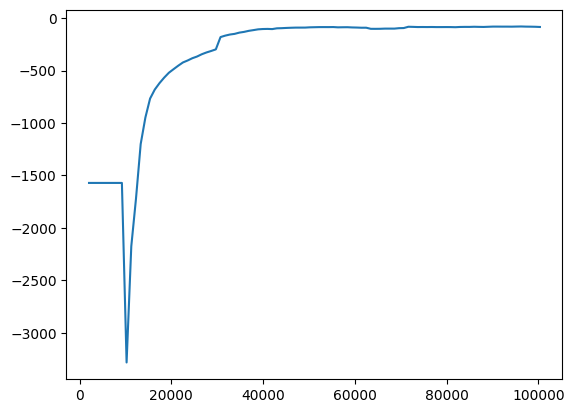

In [16]:
dr_steps, dr_returns = read_tf_log(dr_save_dir)
plt.plot(dr_steps, dr_returns)

In [17]:
### TODO: evaluate the agent from the DR simulation environment
### ("AcrobotDREnv-v0") in the real world environment
### ("AcrobotTargetEnv-v0").  Make sure to run at least 10 trials.
### Report mean and standard deviation. (10 pts)

env = wrap_env(gym.make('AcrobotTargetEnv-v0'))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):
        action = dr_agent.get_action(observation)[0].tolist()
        observation, reward, done, info = env.step(action)
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
print(f'mean: {np.mean(num_steps)}, std: {np.std(num_steps)}')
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Num steps: [172, 135, 184, 253, 178, 171, 184, 186, 151, 123]
mean: 173.7, std: 33.56203211964377


**Question (10 pts):** How does the DR agent perform when evaluated in its training env, `AcrobotDREnv-v0`. You may find plotting the returns during training to be helpful using `read_tf_log`?

**Answer:** The return converges to a certain value, which appeared higher than the previous ones. This mean DR agent can achieve a (sub) optimal policy

**Question (10 pts):**:  How does the DR agent perform in comparison to the sysid agent when transferred to our real world environment? Why is this so?

**Answer**: Based on the simulation above, DR worked a little bit better than the sysid, but the improvement was not as distinct given that the averaged number of steps was still slightly higher than the bare agent one. I believe this might indicate that the run-to-run deviation of this environment is too large to clearly see the improvements and compare their performances.

## Robustness vs Performance Tradeoff

Next, try making your domain randomization less varied by narrowing the distributions of parameters you sample from. Perhaps we introduced too much randomization last round to train a more robust policy in exchange for some potential performance. Instead of scaling the parameters by 80% to 120%, only scale them from 95% to 105%.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[INFO][2024-03-20 19:28:29]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-20 19:28:29]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[ERROR][2024-03-20 19:28:29]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages


      Device:cuda
      Total number of steps:100000


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
[INFO][2024-03-20 19:28:32]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-20 19:28:32]: Saving checkpoint: /content/data/AcrobotDRCompareEnv-v0/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/AcrobotDRCompareEnv-v0/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-20 19:28:32]: Saving checkpoint: /content/data/AcrobotDRCompareEnv-v0/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/AcrobotDRCompareEnv-v0/seed_0/model/model_best.pt.
[INFO][2024-03-20 19:29:16]: Exploration steps: 20480
INFO:EasyRL:Exploration steps: 20480
[INFO][2024-03-20 19:29:16]: Saving checkpoint: /content/data/AcrobotDRCompareEnv-v0/seed_0/model/ckpt_000000020480.pt.
INFO:EasyRL:Saving checkpoint: /content/data/Acrobo

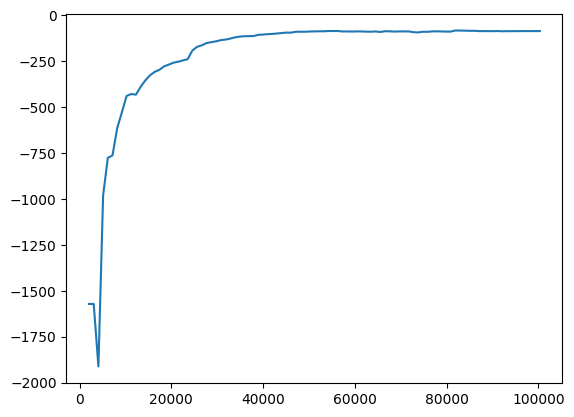

In [18]:
class AcrobotDRCompareEnv(AcrobotEnv):
    """
    Customized Acrobot environment for comparing domain randomization with smaller randomness.

    This environment extends the Acrobot environment to include domain randomization of parameters for comparison.

    Overrides the reset method to randomize the dynamics parameters within a specified range for comparison.

    Attributes:
        All attributes from the AcrobotEnv base class.
    """
    def reset(self):
        """
        Reset the environment and randomize the dynamics parameters slightly for comparison.

        Returns:
            numpy.ndarray: The initial observation after resetting the environment.
        """
        obs = super().reset()

        ### TODO: randomize the dynamics parameters (10 pts)
        scaling_factors = np.random.uniform(0.95, 1.05, size=len(obs))
        for i in range(len(obs)):
            obs[i] *= scaling_factors[i]
        ### ENDTODO

        return obs

env_name = 'AcrobotDRCompareEnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:AcrobotDRCompareEnv',
)

dr_compare_agent, dr_compare_save_dir = train_ppo(env_name='AcrobotDRCompareEnv-v0')
dr_compare_steps, dr_compare_returns = read_tf_log(dr_compare_save_dir)
plt.plot(dr_compare_steps, dr_compare_returns)

In [19]:
### TODO: evaluate the dr_compare_agent in the real world environment
### ("AcrobotTargetEnv-v0").  Make sure to run at least 10 trials.
### Report mean and standard deviation. (10 pts)
env = wrap_env(gym.make('AcrobotTargetEnv-v0'))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):
        action = dr_compare_agent.get_action(observation)[0].tolist()
        observation, reward, done, info = env.step(action)
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
print(f'mean: {np.mean(num_steps)}, std: {np.std(num_steps)}')
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Num steps: [188, 161, 191, 181, 101, 92, 150, 155, 165, 177]
mean: 156.1, std: 32.525220983107864


**Question (10 pts):** Does narrowing the range of domain randomization help with transfer to reality? Why?

**Answer**: Narrowing down the parameter helped decreasing the number of step to achieve a goal compared to 0.8-1.2 range. This is because narrowing down the parameter can increase the performance at some variable range at the cost of reduced performances at different ranges. This is also equivalent to the increased performance at the cost of reduced robustness.

# Knowledge Distillation

Unfortunately, the velocity sensors on the lab's Acrobat broke and are no longer usable. Thus, all of Ben's agents trained thus far that account for velocity in the state space can no longer function.

Fortunately, Ben's professor has yet another idea to allow for transfer between simulation and reality: *knowledge distillation*. A summary of this idea can be found [here](https://intellabs.github.io/distiller/knowledge_distillation.html):

> Knowledge distillation is model compression method in which a small model is trained to mimic a pre-trained, larger model (or ensemble of models). This training setting is sometimes referred to as "teacher-student", where the large model is the teacher and the small model is the student (we'll be using these terms interchangeably).

This scenario is common when in simulation, we can have privileged information that may not be possible in reality (more sensors, perfect state estimation, etc.).

In our case, we could train a teacher network in simulation with full access to a simulated robot with working velocity sensors. We would then train our student network with a more limited state space to predict actions that match that of the teacher. Let's try to implement this.

In [22]:
# defining our environments
class NoVelocityAcrobotEnv(AcrobotEnv):
    """
    Customized Acrobot environment without velocity information in observations.

    This environment extends the Acrobot environment to remove velocity information from observations.

    Attributes:
        book_or_nips (str): Indicates whether the environment is designed for "book" or "nips" format.
    """
    book_or_nips = "book"

    def __init__(self):
        """
        Initialize the NoVelocityAcrobotEnv.

        Sets up the observation space without velocity information.
        """
        AcrobotEnv.__init__(self)
        high = np.array(
            [1.0, 1.0, 1.0, 1.0], dtype=np.float32
        )
        low = -high
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

    def _get_ob(self):
        """
        Get the observation state without velocity information.

        Returns:
            numpy.ndarray: Observation state without velocity information.
        """
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."

        obs = np.array(
            [
                np.cos(s[0]), np.sin(s[0]), np.cos(s[1]), np.sin(s[1]), # no velocity
            ], dtype=np.float32
        )

        return obs

class NoVelocityAcrobotTargetEnv(NoVelocityAcrobotEnv):
    """
    Customized Acrobot environment without velocity information in observations for target modifications.

    This environment extends the NoVelocityAcrobotEnv to incorporate target modifications.

    Attributes:
        book_or_nips (str): Indicates whether the environment is designed for "book" or "nips" format.
    """
    book_or_nips = "nips"


env_name = 'NoVelocityAcrobot-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:NoVelocityAcrobotEnv',
)

env_name = 'NoVelocityAcrobotTarget-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:NoVelocityAcrobotTargetEnv',
)

[INFO][2024-03-20 20:21:36]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-20 20:21:36]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[ERROR][2024-03-20 20:21:36]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


      Device:cuda
      Total number of steps:100000


[INFO][2024-03-20 20:21:38]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-20 20:21:38]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-20 20:21:38]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/model_best.pt.
[INFO][2024-03-20 20:22:23]: Exploration steps: 20480
INFO:EasyRL:Exploration steps: 20480
[INFO][2024-03-20 20:22:23]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000020480.pt.
INFO:EasyRL:Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000020480.pt.
[INFO][2024-03-20 20:23:09]: Exploration steps: 40960
INFO:EasyRL:Exploration steps: 40960
[INFO][2024-03-20 20:23:09]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000040960.pt.
INFO:EasyRL:Saving checkpoint: /content/data

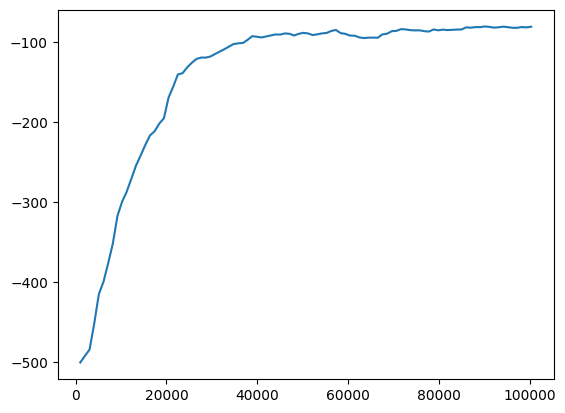

In [21]:
# get our vanilla agent trained on the full simulated basic env
# if you have this cached from Q1 no need to re-train, just run `teacher_agent = agent`
# in practice, we could use one of our better agents (e.g., the agent trained on domain randomization
# or sysid) but let's use the basic agent for simplicity

teacher_agent, teacher_save_dir = train_ppo(env_name="Acrobot-v1")
teacher_steps, teacher_returns = read_tf_log(teacher_save_dir)
plt.plot(teacher_steps, teacher_returns)

# teacher_agent = agent

Now that we have our teacher, let's generate a dataset of observations and policy outputs that we'll try to get our student to later match. Note that solely training on executed *actions* is insufficient, so we'll need to store the parameters of our `Categorical` distribution (the logits representing each of the 3 discrete actions) for every given observation.

In [57]:
num_transitions = 20000

stud_dataset = {
    'obs': np.zeros((num_transitions, 6)),
    'dist_params': np.zeros((num_transitions, 3)),
}

class StudentObsActionDataset(torch.utils.data.Dataset):
    """
    Dataset class for student observations and action parameters.

    This dataset class takes in a student dataset containing observations and distribution parameters,
    and provides methods to retrieve data samples for training.

    Args:
        stud_dataset (dict): A dictionary containing student observations and distribution parameters.
    """
    def __init__(self, stud_dataset):
        """
        Initialize the StudentObsActionDataset.

        Args:
            stud_dataset (dict): A dictionary containing student observations and distribution parameters.
        """
        self.states = stud_dataset['obs']
        self.params = stud_dataset['dist_params']

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return self.states.shape[0]

    def __getitem__(self, idx):
        """
        Get a specific item from the dataset.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            dict: A dictionary containing the state and distribution parameters of the sample.
        """
        sample = dict()
        sample['state'] = self.states[idx][:4] # no velocity information
        sample['dist_params'] = self.params[idx]
        return sample


### TODO: Collect offline dataset of teacher observations and policy outputs
###       from our simulated environment, `Acrobot-v1` which has access to the velocity (30 pts)
'''
note: to get an action out of our `PPOAgent` object, you can pass an observation as a
tensor to the teacher_agent's actor to get a `Categorical` distribution
'''

env = gym.make("Acrobot-v1")

num_steps = 0
while num_steps < num_transitions:
    observation = env.reset()
    done = False
    while not done:
        action_dist, _ = teacher_agent.actor(torch.tensor(observation).float().to(cfg.alg.device))
        action = action_dist.sample()

        stud_dataset["obs"][num_steps] = observation
        stud_dataset["dist_params"][num_steps] = action_dist.logits.cpu().detach().numpy()

        observation, _, done, _ = env.step(action)[0:4]

        num_steps += 1
        if num_steps >= num_transitions:
            break

dset = StudentObsActionDataset(stud_dataset)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Awesome, now that we have our offline dataset, we just need our student policy (which will take in observations without velocities) to output the same distribution over discrete actions! Note that our `StudentObsActionDataset` wrapper is removing velocities for you already.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

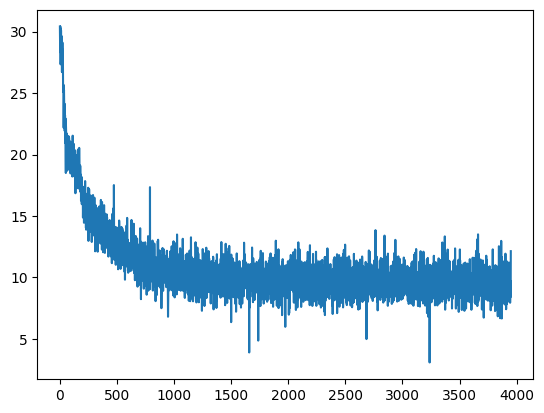

In [70]:
# model
student_body = MLP(
    input_size=4, # no more angular velocity
    hidden_sizes=[64, 64],
    output_size=64,
    hidden_act=nn.Tanh,
    output_act=nn.Tanh
)
act_size = env.action_space.n
student = CategoricalPolicy(
    student_body,
    in_features=64,
    action_dim=act_size
).to(cfg.alg.device)

# setup
optimizer = torch.optim.Adam(student.parameters(), lr=0.0005)
max_epochs = 50
dataloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
criterion = torch.nn.MSELoss()

# train loop
pbar = tqdm(range(max_epochs), desc='Epoch')
losses = []
for iter in pbar:
    avg_loss = []
    avg_loss_tmp = 0
    for batch_idx, sample in enumerate(dataloader):
        states = sample['state'].float().to(cfg.alg.device)
        expert_logits = sample['dist_params'].float().to(cfg.alg.device)

        ### TODO: optimize the student with respect to the data (10 pts)
        optimizer.zero_grad()

        student_dist,_ = student(states)
        student_logits = student_dist.logits

        loss = criterion(student_logits, expert_logits)

        loss.backward()
        optimizer.step()

        avg_loss_tmp += loss.item()

        pbar.set_postfix({'loss': loss.item()})
        losses.append(loss.item())

    avg_loss.append(avg_loss_tmp/batch_idx)
plt.plot(losses)


Let's evaluate the performance of our trained student in a simulated environment with no velocity in the state before we try evaluating it on our real robot with broken velocity sensors.

In [72]:
student.eval()

### TODO: Evaluate the student on `NoVelocityAcrobot-v0`. Be sure to run at least 10 trials
### Report mean and standard deviation. (10 pts)

env = wrap_env(gym.make('NoVelocityAcrobot-v0'))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):
        action_dist, _ = student(torch.tensor(observation).float().to(cfg.alg.device))
        action = action_dist.sample()
        observation, reward, done, info = env.step(action)
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
print(f'mean: {np.mean(num_steps)}, std: {np.std(num_steps)}')
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Num steps: [100, 117, 271, 81, 74, 151, 152, 75, 264, 96]
mean: 138.1, std: 69.9234581524684


In [73]:
student.eval()

### TODO: Evaluate the student on `NoVelocityAcrobotTarget-v0`. Be sure to run at least 10 trials.
### Report mean and standard deviation. (10 pts)

env = wrap_env(gym.make('NoVelocityAcrobotTarget-v0'))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):
        action_dist, _ = student(torch.tensor(observation).float().to(cfg.alg.device))
        action = action_dist.sample()
        observation, reward, done, info = env.step(action)
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
print(f'mean: {np.mean(num_steps)}, std: {np.std(num_steps)}')
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Num steps: [349, 271, 303, 234, 316, 250, 298, 379, 336, 287]
mean: 302.3, std: 42.450088339130694


**Question (10 pts):**:  How does the student agent perform in the simulated environment without velocity (`NoVelocityAcrobot-v0`) in comparison to the teacher on the same environment with velocity measurements (`Acrobot-v1`)?

**Answer**: Student's policy shows much larger number of steps to achieve the goal. This means that teacher's policy works better than the student's policy.

**Question (10 pts):**:  How does the student agent perform in the target environment without velocity (`NoVelocityAcrobotTarget-v0`) in comparison to the other agents we've trained so far? Why is this so?

**Answer**: Student's policy also takes considerably larger steps compared to the other agents. This is because the student agent is being trained only with distilled information filtered by the teacher agent. Therefore it does not have the full access to the environment, which degrades the learning.

# Survey (bonus points, 10 pts)
Please fill out [this anonymous survey](https://docs.google.com/forms/d/1nJdbdBZUqYzWzEJ-BM64Ve0x4r5PThOPQgrboisCJzs/) and enter the code below to receive credit. Thanks!

**Bonus code:** reality_is_often_disappointing

# Submission
Generate an HTML or PDF for submission by running the cells below, ensuring that your plots/code/figures show up nicely and modifying the notebook path as needed to match your Google Drive set up. Alternatively you can run the `jupyer nbconvert` commands on your local machine  after downloading this notebook as an `ipynb`.

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
!jupyter nbconvert --to html '/content/drive/My Drive/Colab Notebooks/csl/hw5/sim2real_solutions.ipynb'